In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from model import define_tables
from pydal import DAL

In [35]:
batch_size = 64
img_height = 224
img_width = 224
image_size = (img_width, img_height)
validation_split = 0.33
data_dir = "data/images_is_flower/train"
test_data_dir = "data/images_is_flower/test"
num_classes = 1

In [6]:
def get_dataset_from_directory(type, seed=123):
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset=type,
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

train_ds = get_dataset_from_directory("training")
val_ds = get_dataset_from_directory("validation")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 862 files belonging to 2 classes.
Using 578 files for training.
Found 862 files belonging to 2 classes.
Using 284 files for validation.


In [7]:
type( train_ds )

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [8]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


In [9]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [10]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs 
)

Epoch 1/30
10/10 [==============================] - 48s 3s/step - loss: 0.7624 - binary_accuracy: 0.5435 - val_loss: 0.5318 - val_binary_accuracy: 0.7500
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 0.5702 - binary_accuracy: 0.7012 - val_loss: 0.4325 - val_binary_accuracy: 0.8204
Epoch 3/30
10/10 [==============================] - 15s 2s/step - loss: 0.4473 - binary_accuracy: 0.8124 - val_loss: 0.3653 - val_binary_accuracy: 0.8697
Epoch 4/30
10/10 [==============================] - 15s 2s/step - loss: 0.3951 - binary_accuracy: 0.8274 - val_loss: 0.3352 - val_binary_accuracy: 0.8873
Epoch 5/30
10/10 [==============================] - 15s 2s/step - loss: 0.3999 - binary_accuracy: 0.8296 - val_loss: 0.3170 - val_binary_accuracy: 0.8803
Epoch 6/30
10/10 [==============================] - 15s 2s/step - loss: 0.3515 - binary_accuracy: 0.8709 - val_loss: 0.3073 - val_binary_accuracy: 0.8803
Epoch 7/30
10/10 [==============================] - 15s 2s/step - loss: 0.34

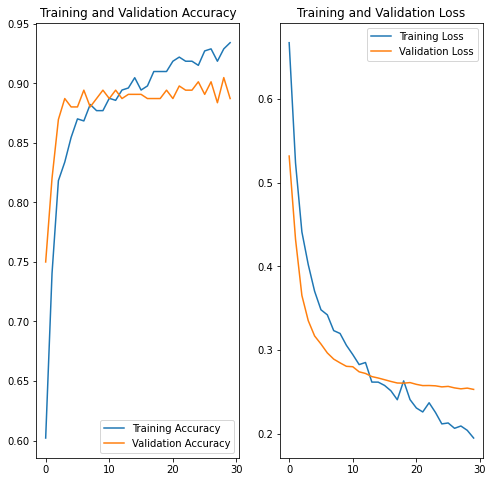

In [11]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
img_filenames = glob(data_dir + '/0/*')
img_filenames += glob(data_dir + '/1/*')
images = []
for image in img_filenames:
    img = keras.preprocessing.image.load_img(
        image, target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    images.append(img_array)

images = np.vstack(images)
predictions = model.predict(images)
scores = predictions[:, 0]


In [13]:
db = DAL('sqlite://flower_storage.db', folder='./data')
define_tables(db)

file_id_re = re.compile(".*[/\\\\]([0-9]+)\.[A-Za-z0-9]*$")
ids_and_is_non_flowers_pred = zip(
    [int(file_id_re.match(name)[1]) for name in img_filenames], list(scores > 0.5)
)
for img_id, is_non_flower_pred in ids_and_is_non_flowers_pred:
    db( db.images.id == img_id ).update(is_non_flower_model_prediction=is_non_flower_pred)

db.commit()

In [33]:
model.save_weights('data/model_is_flower.json')

In [36]:
img_filenames = glob(test_data_dir + '/0/*')
img_filenames += glob(test_data_dir + '/1/*')
images = []
for image in img_filenames:
    img = keras.preprocessing.image.load_img(
        image, target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    images.append(img_array)

images = np.vstack(images)
predictions = model.predict(images)
scores = predictions[:, 0]

In [42]:
class_name_re = re.compile('.*/([01])[\\\\/]')
real_classes = np.array([int( class_name_re.match(name)[1] ) for name in img_filenames])
predicted_classes = 1*(scores > 0.5)
right_pred = predicted_classes == real_classes
acc = right_pred.sum() / len(predicted_classes)
acc

0.877906976744186

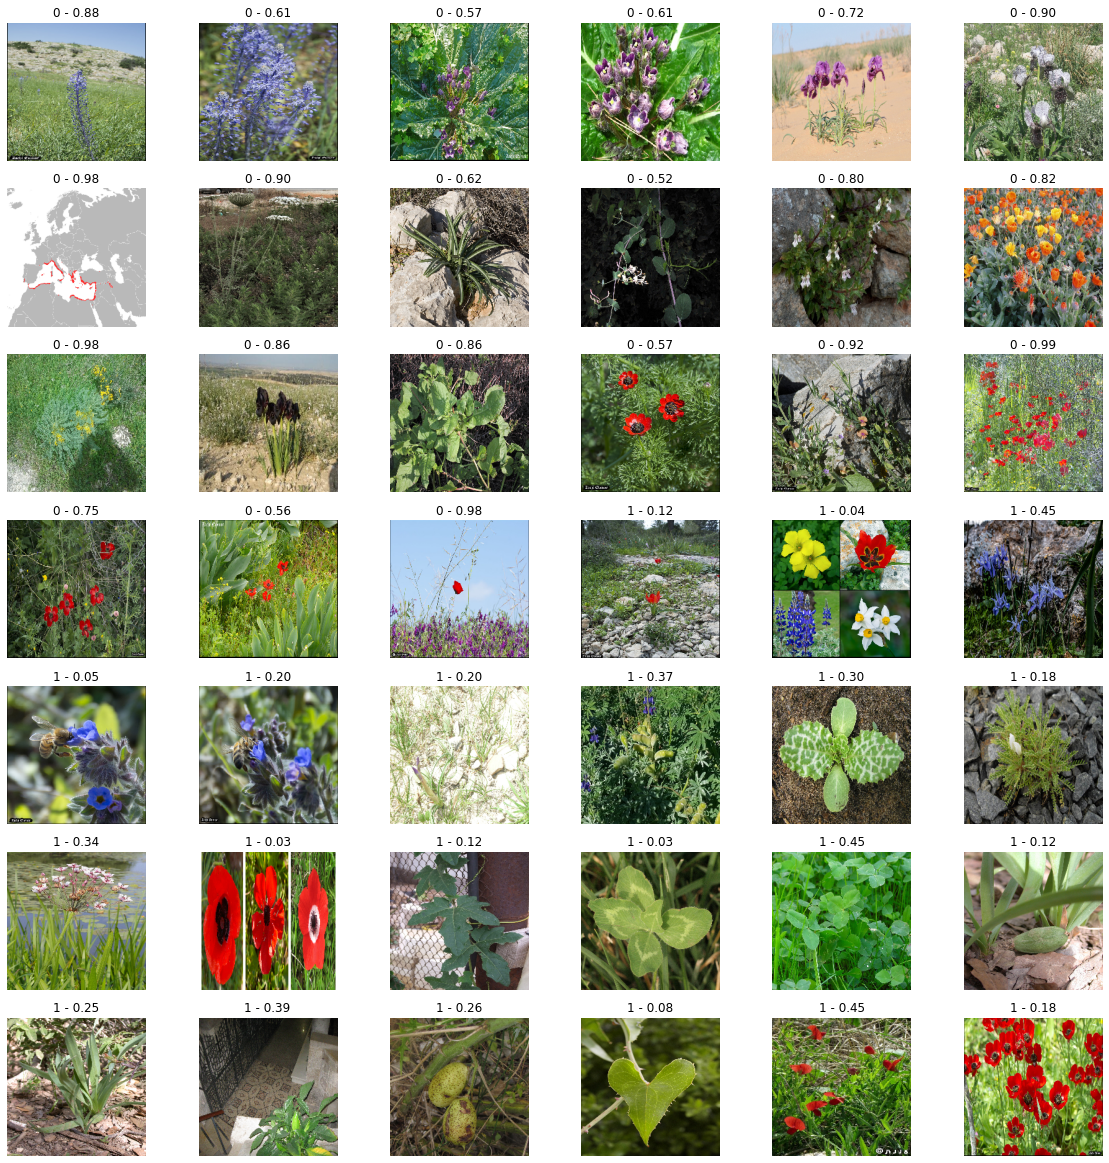

In [43]:
plt.figure(figsize=(20, 30))
class_name_re = re.compile('.*/([01])[\\\\/]')
i = 1
for image, name, score in zip( images, img_filenames, scores ):
    if i > 60:
        break

    class_name = class_name_re.match(name)[1] # this should show only failed predictions
    if (class_name == '0') and (score <= 0.5):
        continue
    if (class_name == '1') and (score > 0.5):
        continue

    ax = plt.subplot(10, 6, i)
    i += 1
    ax.set_title('{} - {:.2f}'.format(class_name, score))
    image = (tf.expand_dims(image, 0))
    plt.imshow(image[0] / 255)
    plt.axis('off')